In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation


In [2]:
def CrossOp(p):
    return np.array([[0,-p[2,0],p[1,0]],
                    [p[2,0],0,-p[0,0]],
                    [-p[1,0],p[0,0],0]])

In [5]:
# Exercise setup
K=np.array([[1000,0,300],
           [0,1000,200],
          [0,0,1]])
R1 = np.identity(3)
R2 = Rotation.from_euler('xyz',[0.7,-0.5,0.8]).as_matrix()
t1 = np.array([[0,0,0]]).T
t2 = np.array([[0.2,2,1]]).T
entri1 = np.hstack([R1.T, t1])
entri2 = np.hstack([R2.T, t2])

Q = np.array([1,0.5,4,1])
q1 = K@entri1@Q
q2 = K@entri2@Q
p1 = q1[:-1]/q1[-1]
p2 = q2[:-1]/q2[-1]


E = CrossOp(t2)@R2

Ftrue = np.linalg.inv(K.T)@E@np.linalg.inv(K)
p1 = entri1@Q
p2 = entri2@Q
q1 = K@p1
q2 = K@p2
print(Ftrue)


[[ 3.29311881e-07  8.19396327e-07  1.79162592e-03]
 [ 5.15532551e-07 -8.76915984e-07  9.31426656e-05]
 [-1.29882755e-03  1.51951700e-03 -1.10072682e+00]]


In [6]:
two_image = np.load('TwoImageData.npy', allow_pickle=True).item()

img1 = two_image['im1']
img2 = two_image['im2']

R1 = two_image['R1']
R2 = two_image['R2']

t1 = two_image['t1']
t2 = two_image['t2']

K = two_image['K']
print(t2.shape)
E = CrossOp(t2)@R2
Ftrue = np.linalg.inv(K.T)@E@np.linalg.inv(K)

print(Ftrue)
print(img1.shape)

(3, 1)
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
(600, 800)


In [7]:
# Exercise 9.1
def Fest_8point(q1,q2):
    n = q1.shape[1]
    B = np.ones([n,9])
    for i in range(n):
        B[i,0] = q1[0,i]*q2[0,i]
        B[i,1] = q1[0,i]*q2[1,i]
        B[i,2] = q1[0,i]
        B[i,3] = q1[1,i]*q2[0,i]
        B[i,4] = q1[1,i]*q2[1,i]
        B[i,5] = q1[1,i]
        B[i,6] = q2[0,i]
        B[i,7] = q2[1,i]
    _,_,VT = np.linalg.svd(B)
    F = np.reshape(VT[-1],(3,3))
    return F
    
    


qs = np.load('qs.npy', allow_pickle=True).item()

q1 = qs['q1']
q2 = qs['q2']

F = Fest_8point(q1,q2)

print(F)
print(Ftrue)
print(Ftrue-(Ftrue[0]/F[0])*F)
print(np.linalg.norm(F,2))

[[-3.07914555e-08  4.49876682e-06 -1.95223414e-03]
 [ 3.61883689e-06  2.24402704e-08  1.48295604e-01]
 [-5.43583727e-04 -1.51520136e-01  9.77264527e-01]]
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
[[ 0.00000000e+00  1.03397577e-25  0.00000000e+00]
 [-1.90887013e-10 -9.52162311e-13  4.18275082e-05]
 [ 3.05584637e-07 -5.86111821e-05 -1.52971931e-04]]
0.9997473486736235


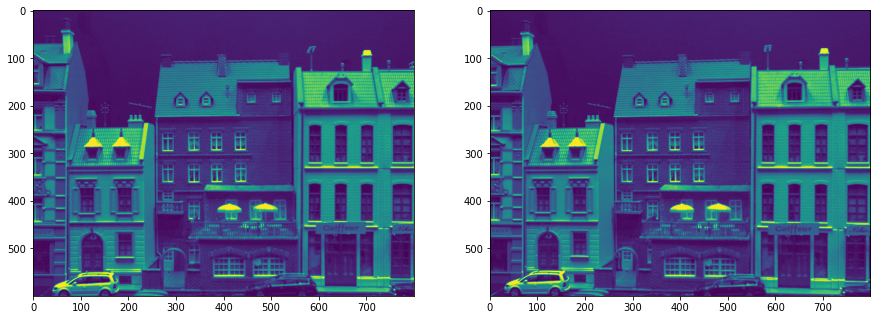

In [9]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
plt.imshow(img1)
fig.add_subplot(1,2,2)
plt.imshow(img2)



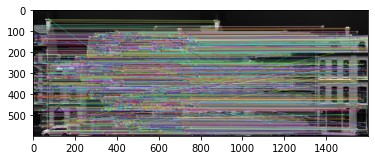

In [10]:
#Exercise 9.2
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.knnMatch(des1,des2,k=1)
good = []
for m in matches:
    if len(m) > 0:
        good.append(m)

'''
good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append[m]
'''   

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(img3)
plt.show()


In [11]:
# Exercise 9.3
def draw_8_points(points1,points2):
    n = points1.shape[0]
    i_1 = np.random.randint(0,n)
    idx = [i_1]
    p = np.zeros((8,3))
    q = np.zeros((8,3))
    p[0] = points1[i_1,:]
    q[0] = points2[i_1,:]
    i_2 = i_1
    count = 1
    while count < 8:
        while i_2 in idx:
            i_2 = np.random.randint(0,n)
        idx.append(i_2)
        
        p[count] = points1[i_2,:]
        q[count] = points2[i_2,:]
        count += 1

    return p,q

def SampsonsDistance(f_est,p1,p2):
    num = (p2@f_est@p1)**2
    den = ((p2.T@f_est)[0])**2 + ((p2.T@f_est)[1])**2 + ((f_est@p1)[0])**2 + ((f_est@p1)[1])**2
    
    
    return num/den


def consensus(f_est,points1,points2,tau):
    inliers = 0
    for i in range(points1.shape[0]):
        dist = SampsonsDistance(f_est,points1[i,:],points2[i,:])
        if dist < tau:
            inliers += 1
    return inliers

def RANSAC_v1(points1, points2,tau,N):
    points1_h = np.hstack([points1,np.ones((points1.shape[0],1))])
    points2_h = np.hstack([points2,np.ones((points2.shape[0],1))])
    max_inliers = 0
    max_inliers_fun = np.array([[0,0,0],[0,0,0],[0,0,0]])
    for i in range(N):
        p_h, q_h = draw_8_points(points1_h,points2_h)
        f_est = Fest_8point(p_h.T,q_h.T)
        inliers = consensus(f_est,points1_h,points2_h,tau)
        if inliers > max_inliers:
            max_inliers = inliers
            max_inliers_fun = f_est
    return max_inliers_fun







In [12]:

points1 = np.array([kp1[good[i][0].queryIdx].pt for i in range(len(good))]).astype(int)
points2 = np.array([kp2[good[i][0].trainIdx].pt for i in range(len(good))]).astype(int)


F_est = RANSAC_v1(points1,points2,tau=3.84*3**2,N=200)
print(F_est)

[[-2.30211096e-06 -3.81251868e-05  1.83097320e-02]
 [ 4.73439337e-05 -2.73723288e-05  6.29980895e-01]
 [-2.23491193e-02 -6.20447969e-01  4.66190578e-01]]


In [13]:
print((F_est*Ftrue).sum()/(np.linalg.norm(F_est)*np.linalg.norm(Ftrue)))

-0.26816069517914565


In [14]:
print((F_est*Ftrue).sum())
print((np.linalg.norm(F_est)*np.linalg.norm(Ftrue)))

-5.8173261542262233e-05
0.00021693433298791007


In [15]:
print(Ftrue-(Ftrue[0]/F_est[0])*F_est)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.38565494e-10  5.58765784e-10  2.88125915e-05]
 [ 3.58659194e-07 -1.93945320e-05 -2.15004681e-04]]


In [17]:
print(F_est*(Ftrue[0]/F_est[0]))
print(Ftrue)

[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-1.37371486e-10 -5.63633849e-10  4.05732811e-06]
 [ 6.48474155e-08 -1.27758760e-05  3.00245317e-06]]
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
